# Projected Least-Squares Quantum Process Tomography

*Tutorial by*: Shahnawaz Ahmed
Email: shahnawaz.ahmed95gmail.com  
GitHub: quantshah

*Original implementation*: [Hyperplane Intersection Projection](https://github.com/Hannoskaj/Hyperplane_Intersection_Projection) by Trystan Surawy-Stepney, Jonas Kahn, 
Richard Kueng and Madalin Guta ([arXiv:2107.01060](https://arxiv.org/abs/2107.01060)).

In this notebook, we will demonstrate 3-qubit quantum process tomography (QPT)
using the projected least squares (PLS) method developed in [1]. We will use
the direct QPT method where the input states are Pauli eigenvectors with Pauli
measurements.

<img src="images/tomography-qpt.png" alt="qpt">

Fig 2 from [1](https://arxiv.org/abs/2107.01060) showing the idea of projected
least squares process tomography.

The main idea is to first find the least squares estimator for the Choi matrix 
representing the process and then project it to a physical CPTP map. The projection
method in the paper is the [Hyperplane Intersection Projection](https://github.com/Hannoskaj/Hyperplane_Intersection_Projection) which was refactored into this
notebook for a simple demonstration.

We will generate the data from a sampling of the true probabilities for various
input states and measurements on which the quantum channel C is applied.

<img src="images/tomography-qpt-pauli.png" alt="qpt">
Fig 4 from [1](https://arxiv.org/abs/2107.01060) direct QPT


Note:
----
The code is refactored from the repository [Hyperplane Intersection Projection](https://github.com/Hannoskaj/Hyperplane_Intersection_Projection)
commited by Jonas Kahn for the paper [arXiv:2107.01060](https://arxiv.org/abs/2107.01060).

References
----------

[1] Surawy-Stepney, T., Kahn, J., Kueng, R., & Guta, M. (2021). Projected Least-Squares Quantum Process Tomography. [arXiv:2107.01060](https://arxiv.org/abs/2107.01060).

[2] Shahnawaz Ahmed, Fernando Quijandría, Anton Frisk Kockum, "Gradient-descent
quantum process tomography by learning Kraus operators," (2022), [arXiv:2208.00812](https://arxiv.org/abs/2208.00812)


In [12]:
import numpy as np


import scipy as sp
from scipy import stats


from qutip import rand_unitary, kraus_to_choi, Qobj, hinton, fidelity


from gd_qpt.gd import GradientDescent


from matplotlib import pyplot as plt
import matplotlib.colors as colors

# The Choi matrix from the Kraus operator

We can construct the Choi matrix from the Kraus operators (using QuTiP) or 
by writing the conversion.

In [13]:
# number of qubits
n = 2 

# Rank of process and number of Kraus operators
rank = 16
num_kraus = 16

# Hilbert space dimension
N = 2**n


def random_kraus(N, weights, rank, density=0.5):
    """Generates a sum of random unitaries to form a process given a set of
    weights and the rank of the process.

    Args:
        N (int): Hilbert space dimension.
        weights (array): Random weights that will be normalized.
        rank (int): The rank of the process.
        density (float): A number between 0, 1 to specifying the density of the
                         random unitaries.

    Returns:
        kraus_ops (array): A (k x N x N) complex-valued array of Kraus operators.
    """
    weights_unnormalized = weights**np.arange(rank)
    weights = weights_unnormalized / (weights_unnormalized).sum()
    kraus_ops = np.array([np.sqrt(w)*rand_unitary(N, density=density) for w in weights])
    return kraus_ops

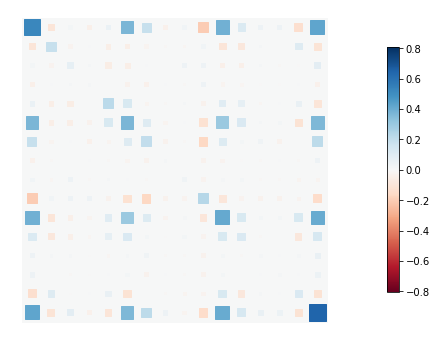

In [14]:
def choi(kraus_ops):
    """Takes the Kraus reprensentation of a channel and returns the Choi matrix.

    Args:
        kraus_ops (np.ndarray): The (k, N, N)-array representing k Kraus ops.

    Returns:
        np.array: A (N^2, N^2) array representing the Choi matrix.
    """
    r, N, N = kraus_ops.shape
    vectorized_kraus = kraus_ops.reshape(r, N ** 2)
    return np.einsum("ij, il -> jl", vectorized_kraus, vectorized_kraus.conj())



kraus_true = random_kraus(N, np.random.uniform(0.5, 1.), rank)
choi_qutip_test = kraus_to_choi([Qobj(kop) for kop in kraus_true])
choi_true = choi(kraus_true)
choi_qutip = Qobj(choi_true, dims=choi_qutip_test.dims, superrep="choi")


hinton(choi_true)
plt.show()

# Sampling from the probabilities obtained by applying the process

The following code is a direct refactor from the original implementation
in (https://github.com/Hannoskaj/Hyperplane_Intersection_Projection).

I have tried to keep the implementation as close as possible without any
change for a fair benchmark.

In [15]:
def sampling(probabilities, cycles=1):
    """Sampling of outcomes according to a Poisson distribution with parameter
    $probabilities \times cycles$, and normalization.

    Args:
        probabilities (np.ndarray): An array of probabilities.
        cycles (int, optional): The number of cycles in the experiment.

    Returns:
        samples (np.ndarray): The samples (normalized).
    """
    samples = SS.poisson.rvs(probas * cycles)
    samples = samples * (probas.sum() / samples.sum())
    return samples


In [16]:
def prod_pauli_vecs(k, U2=None):
    """
    Outputs all the k-tensor products of Pauli vectors, as an array where the
    vectors are the lines.
    Works till k=8 included. Needs $12^k$ complex entries.
    U2 allows to add a rotation to the Pauli vectors, so as to avoid very special cases.
    """
    s2 = np.sqrt(0.5)
    frame_vecs = np.array(
        ([1, 0], [0, 1], [s2, s2], [s2, -s2], [s2, s2 * 1j], [s2, -s2 * 1j])
    )
    if U2 is not None:
        frame_vecs = np.dot(frame_vecs, U2)
    einstein_indices = (
        "ai -> ai",
        "ai, bj -> abij",
        "ai, bj, ck -> abcijk",
        "ai, bj, ck, dl -> abcdijkl",
        "ai, bj, ck, dl, em -> abcdeijklm",
        "ai, bj, ck, dl, em, fn -> abcdefijklmn",
        "ai, bj, ck, dl, em, fn, go -> abcdefgijklmno",
        "ai, bj, ck, dl, em, fn, go, hp -> abcdefghijklmnop",
    )
    return np.einsum(einstein_indices[k - 1], *([frame_vecs] * k)).reshape(6 ** k, -1)


def probas_pauli(k, channel, optimize="optimal"):
    """
    Yields the probability of each Pauli measurement result for 
    the scenario without ancilla.
    For a given Pauli input state and measurement basis, sums to
    one. Hence total sum is $18^k$.

    Input: k is the number of qubits,
           channel are the Kraus operators of the channel.
    Output array $(6^k, 6^k)$. First coordinate input state, second 
    coordinate measured output.
    """
    res = 0
    Pk = prod_pauli_vecs(k)
    # Looping over kraus instead of doing everything in the einsum to
    # avoid excessive memory usage if the rank is high.
    for kraus in channel:
        a = np.einsum("nj, ij, mi -> nm", Pk, kraus, Pk.conj(), optimize="optimal")
        res += a.real ** 2 + a.imag ** 2
    return res


def M_k(k):
    """
    Yields least-square estimators components for the input (or the output)
    state.
    Output is $(6^k, 2^k, 2^k)$.
    First coordinate is the index of the state.
    Other coordinates are the corresponding matrix.
    """
    P1 = prod_pauli_vecs(1)
    # ALERT
    #
    # Here I do not understand the position of the conj(). I would have thought it is on the other P1.
    # But it is this way that yields the right result.
    M_1 = np.einsum("nd, ne -> nde", 3 * P1, P1.conj()) - np.eye(2)
    Mk = np.copy(M_1)
    for i in range(2, k + 1):
        Mk = np.einsum("nde, mfg -> nmdfeg", Mk, M_1).reshape(6 ** i, 2 ** i, 2 ** i)
    return Mk

In [17]:
def ensure_trace(eigvals):
    """
    Assumes sum of eigvals is at least one.

    Finds the value l so that $\sum (\lambda_i - l)_+ = 1$
    and set the eigenvalues $\lambda_i$ to $(\lambda_i - l)_+$.
    """
    trace = eigvals.sum()
    while trace > 1:
        indices_positifs = eigvals.nonzero()
        l = len(indices_positifs[0]) # Number of (still) nonzero eigenvalues
        eigvals[indices_positifs] += (1 - trace) / l  
        eigvals = eigvals.clip(0)
        trace = eigvals.sum() 
    return eigvals


def proj_CP_threshold(rho,  free_trace=True, full_output=False, thres_least_ev=False):
    """
    If thres_least_ev=False and free_trace=False, then projects rho on CP
    trace_one operators.
    
    More generally, changes the eigenvalues without changing the eigenvectors:
    * if free_trace=True and thres_least_ev=False, then projects on CP operators,
    with no trace condition.
    * if thres_least_ev=True, free_trace is ignored. Then we bound from below all 
    eigenvalues by their original value plus the least eigenvalue (which is negative).
    Then all the lower eigenvalues take the lower bound (or zero if it is negative),
    all the higher eigenvalues are unchanged, and there is one eigenvalue in the middle
    that gets a value between its lower bound and its original value, to ensure the
    trace is one.
    """
    eigvals, eigvecs = sp.linalg.eigh(rho) # Assumes hermitian; sorted from lambda_min to lambda_max
    
    least_ev = eigvals[0]
    
    if thres_least_ev:
        threshold = - least_ev # > 0
        evlow = (eigvals - threshold).clip(0)
        toadd = eigvals - evlow
        missing = 1 - evlow.sum()
        if missing < 0: # On this rare event, revert to usual projection
            eigvals = eigvals.clip(0)
            eigvals = ensure_trace(eigvals)
        else:
            inv_cum_toadd =  toadd[::-1].cumsum()[::-1]
            last_more_missing = np.where(inv_cum_toadd >= missing)[0][-1]
            eigvals[:last_more_missing] = evlow[:last_more_missing]
            eigvals[last_more_missing] = eigvals[last_more_missing] + missing - inv_cum_toadd[last_more_missing]    
    else:
        eigvals = eigvals.clip(0)
        if not free_trace:
            eigvals = ensure_trace(eigvals)
        #    
    indices_positifs = eigvals.nonzero()[0]    
    rho_hat_TLS = (eigvecs[:,indices_positifs] * eigvals[indices_positifs]) @ eigvecs[:,indices_positifs].T.conj()
    
    if full_output==2:
        return rho_hat_TLS, least_ev, len(indices_positifs)
    elif full_output:
        return rho_hat_TLS, least_ev
    else:
        return rho_hat_TLS


def proj_TP(rho):
    """
    Projects the Choi matrix rho of a channel on trace-preserving channels.
    """
    d = np.sqrt(len(rho)).astype(int)
    partial_mixed = np.eye(d) / d
    
    # np.trace on the axes corresponding to the system
    correction = np.einsum('de, fg -> dfeg',partial_mixed, (partial_mixed - np.trace(rho.reshape(4 * [d]), axis1=0, axis2=2)))
    return rho + correction.reshape(d**2, d**2)

    
def step2(XW, target):
    """
    Finds a (big) subset of hyperplanes, including the last one, such that
    the projection of the current point on the intersection of the corresponding
    half-spaces is the projection on the intersection of hyperplanes.

    Input: XW is the matrix of the scalar products between the different 
    non-normalized normal directions projected on the subspace TP, written w_i
    in the main functions.
    target is the intercept of the hyperplanes with respect to the starting point,
    on the scale given by w_i.

    Outputs which hyperplanes are kept in subset, and the coefficients on their
    respective w_i in coeffs.
    """
    nb_active = XW.shape[0]
    subset = np.array([nb_active - 1])
    coeffs = [target[-1] / XW[-1, -1]] # Always positive
    for i in range(nb_active - 2, -1, -1):
        test = (XW[i, subset].dot(coeffs) < target[i])
        # The condition to project on the intersection of the hyperplanes is that 
        # all the coefficients are non-negative. This is equivalent to belonging
        # to the normal cone to the facet.
        if test:
            subset = np.r_[i, subset]
            coeffs = sp.linalg.inv(XW[np.ix_(subset, subset)]).dot(target[subset]) 
            # Adding a new hyperplane might generate negative coefficients.
            # We remove the corresponding hyperplanes, except if it is the last 
            # hyperplane, in which case we do not add the hyperplane.
            if coeffs[-1] < 0: 
                subset = subset[1:]
                coeffs = sp.linalg.inv(XW[np.ix_(subset, subset)]).dot(target[subset]) 
            elif not np.all(coeffs >= 0):
                subset = subset[np.where(coeffs >= 0)]
                coeffs = sp.linalg.inv(XW[np.ix_(subset, subset)]).dot(target[subset])
    
    return subset, coeffs


def hyperplane_intersection_projection_switch(
    rho,
    true_Choi,
    maxiter=100,
    free_trace=True,
    least_ev_x_dim2_tol=1e-2,
    all_dists=False,
    dist_L2=True,
    with_evs=False,
    save_intermediate=False,
    HIP_to_alt_switch="first",
    alt_to_HIP_switch="counter",
    min_cos=0.99,
    alt_steps=4,
    missing_w=1,
    min_part=0.3,
    HIP_steps=10,
    max_mem_w=30,
    **kwargs,
):
    """ Switches between alternate projections and HIP, with the following rules:
    * starts in alternate projections.
    * stays in alternate depending on alt_to_HIP_switch:
        ** if 'counter': uses an iterator (alt_steps) of the iteration number to determine the 
        number of consecutive steps before switching. If alt_steps
        is a number, yields this number. If a list cycles on the list.
        ** if 'cos':  switching when two
        successive steps are sufficiently colinear, namely if the cosinus of
        the vectors is at least min_cos.
    * stays in HIP depending on HIP_to_alt_switch:
        ** if 'first': stops HIP when the first active hyperplane
        of the sequence gets discarded. (ex: enter at iteration 7, then leaves when 
        the hyperplane of iteration 7 is not in w_act anymore).
        ** if 'missing', stops when a total of missing_w (default 1) hyperplanes are 
        deemed unnecessary. (ie w_act has lost missing_w member).
        ** if 'part': ends the loop if the length coeff_first * w_first is less than min_part 
        times the step size, ie the length of \sum coeffs_i w_i. This includes the case when
        the first hyperplane is deemed unnecessary, like in 'first'.
        ** if 'counter': uses an iterator (HIP_steps) of the iteration number to determine the 
        number of consecutive steps before switching. Iterator in input iter_choice. If 
        HIP_steps is a number, yields this number. If a list cycles on the list.
    """

    # loops = group.loops
    dim2 = len(rho)
    comp_time = 0
    # x_sq, xiwi = -1, 1 # For the first entry in the loop. Yields the impossible -1.
    sel = "alternate"  # Selector for the step; 'alternate' or 'HIP'.
    if alt_to_HIP_switch == "cos":
        w_norm_ancien = np.zeros(
            (dim2, dim2)
        )  # Not normalized to ensure at least two steps are takenp.
    elif alt_to_HIP_switch == "counter":
        past_al = 0  # number of steps already made in 'alternate' mode.
        alt_step_gen = step_generator(alt_steps)
        current_alt_step = next(alt_step_gen)
    else:
        raise ValueError('Unknown alt_to_HIP_switch. Must be "cos" or "counter".')

    if HIP_to_alt_switch == "counter":
        HIP_step_gen = step_generator(HIP_steps)
        past_HIP = 0
    elif HIP_to_alt_switch == "part":
        pass
    elif HIP_to_alt_switch == "first":
        pass
    elif HIP_to_alt_switch == "missing":
        missed = 0
    else:
        raise ValueError(
            'Unknown HIP_to_alt_switch. Must be "first", "missing", "part" or "counter".'
        )

    dims = (dim2, dim2)

    active = np.array([])
    nb_actives = 0
    XW = np.zeros((0, 0))
    w_act = np.zeros([0, dim2, dim2])
    target = np.array([])
    coeffs = np.array([])

    # rho is on CP, we first project on TP. Outside the loop because we also end on TP.
    rho = proj_TP(rho)

    if save_intermediate:
        rhoTP = [np.expand_dims(rho, 0)]

    least_ev_list = []

    for m in range(maxiter):
        rho_after_CP, least_ev = proj_CP_threshold(rho, free_trace, full_output=True)

        if save_intermediate:
            rhoTP.append(np.expand_dims(rho, 0))
        least_ev_list.append(least_ev)

        # Breaks here because the (- least_ev) might increase on the next rho
        if (sel == "alternate") or (m >= (maxiter - 2)):  # Ensures last ones are AP.
            print("Alternate projections mode")
            # On TP and intersection with hyperplane
            if alt_to_HIP_switch == "cos":
                w_new = proj_TP(rho_after_CP) - rho
                norm_w = sp.linalg.norm(w_new)
                change = np.vdot(w_new / norm_w, w_norm_ancien).real > min_cos
                w_norm_ancien = w_new / norm_w

                # If change with alt_steps, the current projection is transformed into
                # the first HIP step.
                if change:
                    active = np.array([m])
                    nb_actives = 1
                    XW = np.array([[norm_w ** 2]])
                    w_act = np.array([w_new])
                    coeffs = np.array([sp.linalg.norm(rho - rho_after_CP) ** 2 / norm_w ** 2])
                    target = np.array([0.0])
                    rho += coeffs[0] * w_new
                else:
                    rho += w_new

            elif alt_to_HIP_switch == "counter":
                rho = proj_TP(rho_after_CP)
                past_al += 1
                change = past_al >= current_alt_step

                if change:
                    active = np.array([])
                    nb_actives = 0
                    XW = np.zeros((0, 0))
                    w_act = np.zeros([0, dim2, dim2])
                    target = np.array([])
                    coeffs = np.array([])

            if change:
                if HIP_to_alt_switch == "missing":
                    missed = 0
                elif HIP_to_alt_switch == "counter":
                    past_HIP = 0
                    current_HIP_step = next(HIP_step_gen)
                sel = "HIP"

        elif sel == "HIP":  # No other possibility
            print(f"HIP mode. Active hyperplanes: {1 + nb_actives}")

            sq_norm_x_i = sp.linalg.norm(rho - rho_after_CP) ** 2
            w_i = proj_TP(rho_after_CP) - rho
            xiwi = sp.linalg.norm(w_i) ** 2

            XW = np.column_stack([XW, np.zeros(nb_actives)])
            XW = np.row_stack([XW, np.zeros(nb_actives + 1)])
            new_xw = np.einsum(
                "ij, kij -> k", w_i.conj(), w_act
            ).real  # Notice that the scalar product are all real
            # since the matrices are self-adjoint.
            XW[-1, :-1] = new_xw
            XW[:-1, -1] = new_xw
            XW[-1, -1] = xiwi
            target = np.r_[target, sq_norm_x_i]

            active = np.concatenate((active, [m]))
            w_act = np.concatenate([w_act, [w_i]])

            subset, coeffs = step2(XW, target)

            if HIP_to_alt_switch == "missing":
                missed += len(active) - len(
                    subset
                )  # Don't move this after the update to active !!!

            XW = XW[np.ix_(subset, subset)]
            active = active[subset]
            nb_actives = len(active)
            w_act = w_act[subset]
            target = np.zeros((nb_actives,))
            rho += np.einsum("k, kij -> ij", coeffs, w_act)

            if HIP_to_alt_switch in ["first", "part"]:
                if (
                    subset[0] != 0
                ) or nb_actives > max_mem_w:  # max_mem_w limits memory usage
                    change = True
                elif HIP_to_alt_switch == "part":
                    step_size = np.sqrt(np.einsum("i, ij, j", coeffs, XW, coeffs))
                    w_first_contrib = coeffs[0] * np.sqrt(XW[0, 0])
                    change = min_part * step_size >= w_first_contrib
                else:
                    change = False
            elif HIP_to_alt_switch in ["counter", "missing"]:

                # Limits memory usage
                if nb_actives > max_mem_w:
                    nb_actives -= 1
                    active = active[1:]
                    w_act = w_act[1:]
                    target = target[1:]
                    XW = XW[1:, 1:]
                    if HIP_to_alt_switch == "missing":
                        missed += 1
                # End max_mem_w case

                if HIP_to_alt_switch == "missing":
                    change = missed >= missing_w
                elif HIP_to_alt_switch == "counter":
                    past_HIP += 1
                    change = past_HIP >= current_HIP_step

            if change:
                if alt_to_HIP_switch == "cos":
                    w_norm_ancien = np.zeros(
                        (dim2, dim2)
                    )  # Ensures two alternate steps. Also possible to
                    # use w_norm_ancien = w_i / sqrt(xiwi)
                elif alt_to_HIP_switch == "counter":
                    past_al = 0
                    current_alt_step = next(alt_step_gen)
                sel = "alternate"

        else:
            raise ValueError('How did I get there? Typo on "HIP" or "alternate"?')

    return rhoTP, least_ev_list, m


In [18]:
def final_CPTP_by_mixing(rho, full_output=False):
    """
    Assumed to be in TP.
    """
    d = rho.shape[0]
    abs_least_ev = - sp.linalg.eigvalsh(rho, subset_by_index=[0,0])[0]
    if full_output:
        return (rho + abs_least_ev * np.eye(d)) / (1. + d * abs_least_ev), - abs_least_ev
    else:
        return (rho + abs_least_ev * np.eye(d)) / (1. + d * abs_least_ev)


def get_pls_estimate(rho):
    """[summary]
    """
    depo_rtol = 1e-16
    depo_tol =  1e-16


    options_proj={
            "maxiter": 500,
            "HIP_to_alt_switch": "first",
            "missing_w": 3,
            "min_part": 0.1,
            "HIP_steps": 10,
            "alt_steps": 10,
            "alt_to_HIP_switch": "cos",
            "min_cos": 0.99,
            "max_mem_w": 30,
            "genarg_alt": (1, 3, 20),
            "genarg_HIP": (5,),
        }

    all_dists=False
    first_CP_threshold_least_ev=True,
    all_dists=False,
    dist_L2=True,
    with_evs=False,
    keep_key_channels=False,
    keep_main_eigenvectors=0,
    save_intermediate=True

    proj = "HIPswitch"


    first_CP_threshold_least_ev=True,
    rhoCP, LS_least_ev = proj_CP_threshold(rho, full_output=True, thres_least_ev=first_CP_threshold_least_ev)
    ls_rel = -LS_least_ev * depo_rtol
    least_ev_x_dim2_tol = np.maximum(ls_rel, depo_tol)


    rho_list, least_ev, iterations = hyperplane_intersection_projection_switch(
                rhoCP,
                choi_true,
                **options_proj,
                least_ev_x_dim2_tol=least_ev_x_dim2_tol,
                all_dists=all_dists,
                with_evs=with_evs,
                dist_L2=dist_L2,
                save_intermediate=save_intermediate,
            )

    choi_pls = final_CPTP_by_mixing(rho_list[-1][0])

    return choi_pls


def Choi_LS_from_Pauli_freq(n, freq, optimize='optimal'):
    """
    Direct version, when memory is not a problem. If it is, 
    Choi_LS_Pauli_from_channel_mem will have a lighter load.
    
    Yields the least-square estimator of the Choi matrix in a Pauli setting without
    ancilla, when the result of the measurements have frequency freq.
    Input: n is the number of qubits.
           freq is the frequency of each result. Shape $(6^n, 6^n)$. Sums to the 
           number of measurement settings $18^n$.
    Output: Matrix $(4^n, 4^n)$. Trace one. Not completely positive, 
            nor trace-preserving.
        
    """
    Pk = prod_pauli_vecs(n)
    Mk = M_k(n)
    Choi_est = np.einsum('nm, nde, mfg -> fegd', freq, Mk, Mk, optimize=optimize) # Ordre des indices étrange 
    return Choi_est.reshape(4**n, 4**n) / 18**n

In [19]:
probas = probas_pauli(n, kraus_true)
order = 100
data = probas + np.random.normal(0., 1/order, size=probas.shape)
choi_ls_est = Choi_LS_from_Pauli_freq(n, data)
choi_pls = get_pls_estimate(choi_ls_est)*2**n

choi_pls_qutip = Qobj(choi_pls, dims=choi_qutip.dims, superrep="choi")
pls_fidelity =  fidelity(choi_pls_qutip/2**n, choi_qutip/2**n)

Alternate projections mode
Alternate projections mode
Alternate projections mode
HIP mode. Active hyperplanes: 2
Alternate projections mode
Alternate projections mode
Alternate projections mode
HIP mode. Active hyperplanes: 2
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projecti

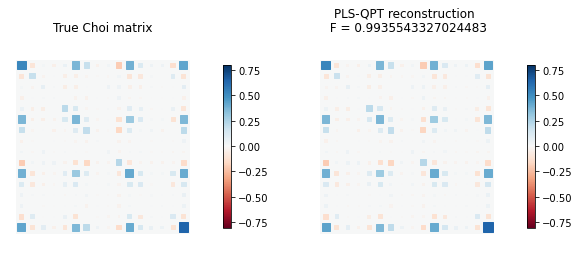

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
hinton(choi_true, ax=ax[0])
hinton(choi_pls, ax=ax[1])

ax[0].set_title("True Choi matrix")
ax[1].set_title(f"PLS-QPT reconstruction \n F = {pls_fidelity}")
plt.show()

In [21]:
Pk = prod_pauli_vecs(n)
GD = GradientDescent(N, num_kraus)
choi_gd = GD.fit(data, Pk, Pk, batch_size=32)

  0%|          | 0/1000 [00:00<?, ?it/s]

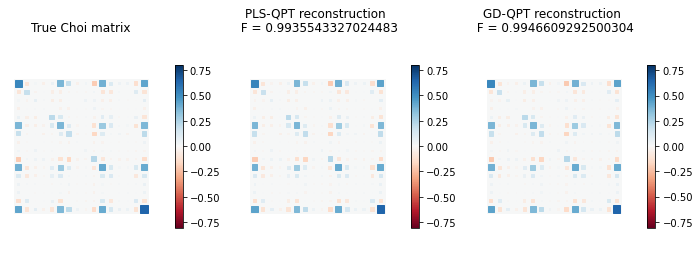

In [22]:
choi_gd_qutip = Qobj(choi_gd, dims=choi_qutip.dims, superrep="choi")
gd_fidelity =  fidelity(choi_gd_qutip/2**n, choi_qutip/2**n)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

hinton(choi_true, ax=ax[0])
hinton(choi_pls, ax=ax[1])
hinton(choi_gd, ax=ax[2])

ax[0].set_title("True Choi matrix")
ax[1].set_title(f"PLS-QPT reconstruction \n F = {pls_fidelity}")
ax[2].set_title(f"GD-QPT reconstruction \n F = {gd_fidelity}")

plt.show()